In [39]:
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler #
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [40]:
df = pd.read_excel("df_Merge_ASDnVehiclenCompany.xlsx")
df.drop(columns='Unnamed: 0', axis=1, inplace=True)
print(df.shape)
df.head()

(299, 69)


,LKR-ID,Landkreis,KFZ,Fläche [ha],LF gesamt [ha],Anteil LF [%],Lw. Betriebe gesamt,Betriebe bis 5 ha,Betriebe 5-20 ha,Betriebe 20-50 ha,...,Betriebe Öko-LF in Umst.,LF ökologisch [ha],LW-Fläche unter 5 ha,LW-Fläche 10-20 ha,LW-Fläche 20-50 ha,LW-Fläche 50-100 ha,LW-Fläche 100-200 ha,LW-Fläche über 200 ha,Number of machinery,Sum of Number of Tractors
0,7140,LK Rhein-Hunsrück-Kreis,SIM,93414.311,37301,39.900,719,31,300,150,...,25,1913,61,3377,4979,9330,10797,8757,1,497
1,7141,LK Rhein-Lahn-Kreis,EMS,75847.110,26679,35.200,491,31,178,92,...,180,1813,69,1931,3068,7318,9321,4973,23,450
2,7143,LK Westerwaldkreis,WW,95960.505,26296,27.400,503,26,196,115,...,452,6862,80,2358,3816,6100,8649,5294,2,751
3,7231,LK Bernkastel-Wittlich,WIL,113297.133,34098,30.100,1319,645,342,129,...,226,2728,1449,3417,4083,7615,0,0,5,920
4,7232,LK Eifelkreis Bitburg-Prüm,BIT,157901.855,78482,49.700,1324,34,415,288,...,996,6309,73,5154,9951,24598,27627,11079,49,1596


In [41]:
# Check for duplicates
idsUnique = len(set(df.Landkreis))
idsTotal = df.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 299 total entries


In [43]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = df.corr()
corr.sort_values(["Number of machinery"], ascending = False, inplace = True)
print(corr["Number of machinery"].head(20))

Find most important features relative to target
Number of machinery         1.000
Betriebe Zuchtsauen         0.607
Ackerbaubetriebe            0.601
Betriebe 50-100 ha          0.593
LW-Fläche 50-100 ha         0.589
Betriebe Schweine           0.554
Sum of Number of Tractors   0.533
Viehbestand GV              0.527
Anzahl Zuchtsauen           0.521
Lw. Betriebe gesamt         0.516
Betriebe Viehhaltung        0.514
LW-Fläche 20-50 ha          0.506
Anzahl Schweine             0.504
Betriebe 20-50 ha           0.498
Kartoffeln [ha]             0.477
Körnermais [ha]             0.468
Silomais [ha]               0.464
Fläche Triticale [ha]       0.460
Fläche Grünernte [ha]       0.454
Bestand Rinder              0.407
Name: Number of machinery, dtype: float64


In [44]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("Number of machinery")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
df_num = df[numerical_features]
df_cat = df[categorical_features]

Numerical features : 66
Categorical features : 2


In [45]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(df_num.isnull().values.sum()))
# df_num = df_num.fillna(train_num.median())
# print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 0


# log transformation

In [46]:
# Log transform of the skewed numerical features to lessen impact of outliers
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = df_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
df_num[skewed_features] = np.log1p(df_num[skewed_features])

# Log transform the target for official scoring
df["Number of machinery"] = np.log1p(df["Number of machinery"])

63 skewed numerical features to log transform


# Standardize numerical features
### Scale to [0;1] (give equal weight to all features, assuming a linear distribution of values and no significant outliers)
### Shift mean to 0 (to center the data set; this will not affect the output at all for most algorithms.)

In [47]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

# Modeling

In [48]:
# Join categorical and numerical features
# train = pd.concat([df_num, df_cat], axis = 1)
train = df_num
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.25, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10)) # k-fold, set k as 10
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

New number of features : 66
X_train : (224, 66)
X_test : (75, 66)
y_train : (224,)
y_test : (75,)


# 1* Linear Regression without regularization

RMSE on Training set : 0.9871739262846895
RMSE on Test set : 5.130313868068498
Intercept: -3.736082756095743
R2 score of train:  0.6752504128442788
R2 score of test:  0.2517957567099054


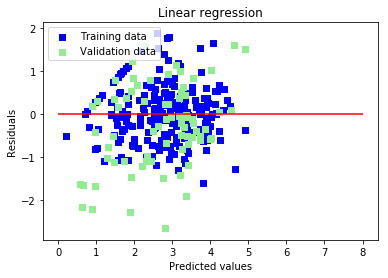

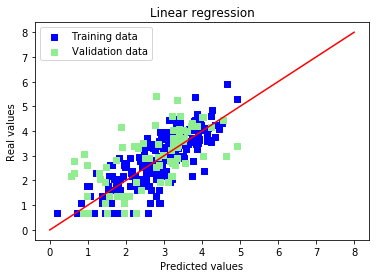

,coef,features
0,0.973,Betriebe 100-200 ha
1,0.658,Ackerbaubetriebe
2,0.639,Fläche [ha]
3,0.608,Sum of Number of Tractors
4,0.429,Betriebe 20-50 ha
5,0.245,Betriebe Dauerkulturen
6,0.196,Betriebe 5-20 ha
7,0.159,Betriebe 50-100 ha
8,0.124,Betriebe Rinder
9,0.102,Bestand Rinder


In [49]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# printing values
lr_coef = list(zip(lr.coef_, df_num.columns))
lr_coef.sort(reverse=True)
df_lr_coef = pd.DataFrame.from_records(lr_coef, columns=['coef', 'features'])

print('Intercept:', lr.intercept_)
print('R2 score of train: ', r2_train)
print('R2 score of test: ', r2_test)


# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 8, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 8], [0, 8], c = "red")
plt.show()

df_lr_coef.head(20)